# Sender Time Series Analysis for Fraud Detection

This notebook performs comprehensive temporal analysis of sender behavior with focus on:
1. **Frequency-based features** at multiple time scales
2. **Temporal patterns** that distinguish phishing from legitimate senders
3. **Burst detection** and campaign identification
4. **Statistical validation** of discriminative features

**Goal:** Extract temporal features that complement graph-based features for fraud detection

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats, signal
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 100)

print("✅ Libraries loaded successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries loaded successfully
Pandas version: 2.3.3
NumPy version: 2.3.4


In [2]:
# Load the data
print("="*80)
print("LOADING DATA")
print("="*80)

# Update this path to your actual data location
df = pd.read_csv("/Users/cindy/Desktop/DSA4263_Group_Project/data/processed/cleaned_date_merge.csv")
df['date'] = pd.to_datetime(df['date'], format='ISO8601')

# Sort by sender and date for time series analysis
df = df.sort_values(['sender', 'date'])

print(f"\n📊 Dataset Overview:")
print(f"  • Total emails: {len(df):,}")
print(f"  • Unique senders: {df['sender'].nunique():,}")
print(f"  • Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  • Phishing emails: {(df['label']==1).sum():,} ({(df['label']==1).mean()*100:.1f}%)")
print(f"  • Legitimate emails: {(df['label']==0).sum():,} ({(df['label']==0).mean()*100:.1f}%)")

LOADING DATA

📊 Dataset Overview:
  • Total emails: 49,083
  • Unique senders: 31,001
  • Date range: 1990-01-01 17:57:46 to 2022-12-27 10:56:49
  • Phishing emails: 27,707 (56.4%)
  • Legitimate emails: 21,376 (43.6%)


## Part 1: Multi-Scale Frequency Analysis

In [3]:
print("="*80)
print("MULTI-SCALE FREQUENCY FEATURE EXTRACTION")
print("="*80)

def calculate_frequency_features(sender_df):
    """
    Calculate frequency-based features at multiple time scales with percentiles
    """
    features = {}
    
    # Basic info
    features['total_emails'] = len(sender_df)
    features['label'] = sender_df['label'].mode()[0] if len(sender_df['label'].mode()) > 0 else sender_df['label'].iloc[0]
    
    if len(sender_df) == 1:
        # Single email sender - set defaults
        features['emails_per_minute_max'] = 1
        features['emails_per_5min_max'] = 1
        features['emails_per_15min_max'] = 1
        features['emails_per_30min_max'] = 1  # NEW: 30-minute window
        features['emails_per_hour_max'] = 1
        features['emails_per_day_max'] = 1
        features['burst_ratio'] = 1
        features['concentration_1hr'] = 1
        features['active_duration_hours'] = 0
        features['spikiness_5min'] = 1  # NEW: Spikiness metric
        return features
    
    # Sort by date
    sender_df = sender_df.sort_values('date')
    
    # Calculate time span
    time_span = (sender_df['date'].max() - sender_df['date'].min())
    features['active_duration_hours'] = time_span.total_seconds() / 3600
    
    # Create continuous time series with 1-minute bins
    start_time = sender_df['date'].min().floor('min')
    end_time = sender_df['date'].max().ceil('min')
    
    # Limit to reasonable range to avoid memory issues
    max_minutes = min(int((end_time - start_time).total_seconds() / 60), 10000)
    
    if max_minutes > 0:
        time_index = pd.date_range(start=start_time, end=end_time, freq='min')[:max_minutes]
        ts = pd.Series(0, index=time_index)
        
        # Count emails per minute
        for date in sender_df['date']:
            minute_key = date.floor('min')
            if minute_key in ts.index:
                ts[minute_key] += 1
        
        # Multi-scale frequency features with PERCENTILES
        # 1-minute scale
        features['emails_per_minute_max'] = ts.max()
        features['emails_per_minute_mean'] = ts[ts > 0].mean() if (ts > 0).any() else 0
        features['emails_per_minute_p90'] = ts.quantile(0.90)  # NEW
        features['emails_per_minute_p95'] = ts.quantile(0.95)  # NEW
        features['emails_per_minute_p99'] = ts.quantile(0.99)  # NEW
        
        # 5-minute scale
        if len(ts) >= 5:
            ts_5min = ts.rolling(5, min_periods=1).sum()
            features['emails_per_5min_max'] = ts_5min.max()
            features['emails_per_5min_p90'] = ts_5min.quantile(0.90)  # NEW
            features['emails_per_5min_p95'] = ts_5min.quantile(0.95)
            features['emails_per_5min_p99'] = ts_5min.quantile(0.99)  # NEW
            features['emails_per_5min_median'] = ts_5min.median()  # NEW
            # Spikiness: max/median ratio
            features['spikiness_5min'] = ts_5min.max() / ts_5min.median() if ts_5min.median() > 0 else 1  # NEW
        else:
            features['emails_per_5min_max'] = features['total_emails']
            features['emails_per_5min_p90'] = features['total_emails']
            features['emails_per_5min_p95'] = features['total_emails']
            features['emails_per_5min_p99'] = features['total_emails']
            features['emails_per_5min_median'] = features['total_emails']
            features['spikiness_5min'] = 1
        
        # 15-minute scale
        if len(ts) >= 15:
            ts_15min = ts.rolling(15, min_periods=1).sum()
            features['emails_per_15min_max'] = ts_15min.max()
            features['emails_per_15min_p90'] = ts_15min.quantile(0.90)  # NEW
            features['emails_per_15min_p95'] = ts_15min.quantile(0.95)
            features['emails_per_15min_p99'] = ts_15min.quantile(0.99)  # NEW
            features['spikiness_15min'] = ts_15min.max() / ts_15min.median() if ts_15min.median() > 0 else 1  # NEW
        else:
            features['emails_per_15min_max'] = features['total_emails']
            features['emails_per_15min_p90'] = features['total_emails']
            features['emails_per_15min_p95'] = features['total_emails']
            features['emails_per_15min_p99'] = features['total_emails']
            features['spikiness_15min'] = 1
        
        # 30-minute scale (NEW - suggested for campaigns)
        if len(ts) >= 30:
            ts_30min = ts.rolling(30, min_periods=1).sum()
            features['emails_per_30min_max'] = ts_30min.max()
            features['emails_per_30min_p95'] = ts_30min.quantile(0.95)
            features['emails_per_30min_variance'] = ts_30min.var()  # NEW: variance within windows
        else:
            features['emails_per_30min_max'] = features['total_emails']
            features['emails_per_30min_p95'] = features['total_emails']
            features['emails_per_30min_variance'] = 0
        
        # 1-hour scale
        if len(ts) >= 60:
            ts_hour = ts.rolling(60, min_periods=1).sum()
            features['emails_per_hour_max'] = ts_hour.max()
            features['emails_per_hour_mean'] = ts_hour[ts_hour > 0].mean() if (ts_hour > 0).any() else 0
            features['emails_per_hour_p90'] = ts_hour.quantile(0.90)  # NEW
            features['emails_per_hour_p95'] = ts_hour.quantile(0.95)  # NEW
            features['concentration_1hr'] = ts_hour.max() / features['total_emails']
        else:
            features['emails_per_hour_max'] = features['total_emails']
            features['emails_per_hour_mean'] = features['total_emails']
            features['emails_per_hour_p90'] = features['total_emails']
            features['emails_per_hour_p95'] = features['total_emails']
            features['concentration_1hr'] = 1.0
    else:
        # All emails in same minute
        features['emails_per_minute_max'] = features['total_emails']
        features['emails_per_minute_mean'] = features['total_emails']
        features['emails_per_minute_p90'] = features['total_emails']
        features['emails_per_minute_p95'] = features['total_emails']
        features['emails_per_minute_p99'] = features['total_emails']
        features['emails_per_5min_max'] = features['total_emails']
        features['emails_per_5min_p90'] = features['total_emails']
        features['emails_per_5min_p95'] = features['total_emails']
        features['emails_per_5min_p99'] = features['total_emails']
        features['emails_per_5min_median'] = features['total_emails']
        features['spikiness_5min'] = 1
        features['emails_per_15min_max'] = features['total_emails']
        features['emails_per_15min_p90'] = features['total_emails']
        features['emails_per_15min_p95'] = features['total_emails']
        features['emails_per_15min_p99'] = features['total_emails']
        features['spikiness_15min'] = 1
        features['emails_per_30min_max'] = features['total_emails']
        features['emails_per_30min_p95'] = features['total_emails']
        features['emails_per_30min_variance'] = 0
        features['emails_per_hour_max'] = features['total_emails']
        features['emails_per_hour_mean'] = features['total_emails']
        features['emails_per_hour_p90'] = features['total_emails']
        features['emails_per_hour_p95'] = features['total_emails']
        features['concentration_1hr'] = 1.0
    
    # Daily scale
    daily_counts = sender_df.groupby(sender_df['date'].dt.date).size()
    features['emails_per_day_max'] = daily_counts.max()
    features['emails_per_day_mean'] = daily_counts.mean()
    features['active_days'] = len(daily_counts)
    
    # Burst ratio
    if features['emails_per_hour_mean'] > 0:
        features['burst_ratio'] = features['emails_per_hour_max'] / features['emails_per_hour_mean']
    else:
        features['burst_ratio'] = 1
    
    return features

# Apply to all senders
print("\n⏳ Extracting frequency features for all senders...")
frequency_features = []
for sender, group in df.groupby('sender'):
    features = calculate_frequency_features(group)
    features['sender'] = sender
    frequency_features.append(features)

freq_df = pd.DataFrame(frequency_features)
print(f"✅ Frequency features extracted for {len(freq_df)} senders")
print(f"\n📊 Feature columns created ({len([c for c in freq_df.columns if c not in ['sender', 'label']])} features):")
feature_cols_freq = [c for c in freq_df.columns if c not in ['sender', 'label']]
for i in range(0, len(feature_cols_freq), 4):
    print("  ", ", ".join(feature_cols_freq[i:i+4]))

MULTI-SCALE FREQUENCY FEATURE EXTRACTION

⏳ Extracting frequency features for all senders...
✅ Frequency features extracted for 31001 senders

📊 Feature columns created (30 features):
   total_emails, emails_per_minute_max, emails_per_5min_max, emails_per_15min_max
   emails_per_30min_max, emails_per_hour_max, emails_per_day_max, burst_ratio
   concentration_1hr, active_duration_hours, spikiness_5min, emails_per_minute_mean
   emails_per_minute_p90, emails_per_minute_p95, emails_per_minute_p99, emails_per_5min_p90
   emails_per_5min_p95, emails_per_5min_p99, emails_per_5min_median, emails_per_15min_p90
   emails_per_15min_p95, emails_per_15min_p99, spikiness_15min, emails_per_30min_p95
   emails_per_30min_variance, emails_per_hour_mean, emails_per_hour_p90, emails_per_hour_p95
   emails_per_day_mean, active_days


## Part 2: Advanced Temporal Pattern Features

In [4]:
print("="*80)
print("ADVANCED TEMPORAL PATTERN EXTRACTION")
print("="*80)

def calculate_temporal_patterns(sender_df):
    """
    Extract advanced temporal patterns and rhythms
    """
    features = {}
    
    if len(sender_df) == 1:
        # Defaults for single email senders
        features['inter_email_mean'] = 0
        features['inter_email_std'] = 0
        features['inter_email_cv'] = 0
        features['hour_entropy'] = 0
        features['day_entropy'] = 0
        features['time_consistency_score'] = 1
        features['is_burst_sender'] = 0
        features['night_ratio'] = 1 if sender_df.iloc[0]['date'].hour >= 22 or sender_df.iloc[0]['date'].hour < 6 else 0
        features['business_hours_ratio'] = 1 if 9 <= sender_df.iloc[0]['date'].hour < 18 else 0
        features['weekend_ratio'] = 1 if sender_df.iloc[0]['date'].dayofweek >= 5 else 0
        return features
    
    # Sort by date
    sender_df = sender_df.sort_values('date')
    
    # Inter-email intervals
    intervals = sender_df['date'].diff().dropna().dt.total_seconds() / 60  # in minutes
    if len(intervals) > 0:
        features['inter_email_mean'] = intervals.mean()
        features['inter_email_std'] = intervals.std()
        features['inter_email_min'] = intervals.min()
        features['inter_email_max'] = intervals.max()
        features['inter_email_cv'] = intervals.std() / intervals.mean() if intervals.mean() > 0 else 0
        
        # Detect burst pattern (many emails with < 5 min intervals)
        rapid_emails = (intervals < 5).sum()
        features['rapid_succession_ratio'] = rapid_emails / len(intervals)
        features['is_burst_sender'] = 1 if features['rapid_succession_ratio'] > 0.5 else 0
    else:
        features['inter_email_mean'] = 0
        features['inter_email_std'] = 0
        features['inter_email_min'] = 0
        features['inter_email_max'] = 0
        features['inter_email_cv'] = 0
        features['rapid_succession_ratio'] = 0
        features['is_burst_sender'] = 0
    
    # Temporal entropy (randomness of patterns)
    hours = sender_df['date'].dt.hour
    hour_counts = hours.value_counts()
    hour_probs = hour_counts / len(hours)
    features['hour_entropy'] = entropy(hour_probs)
    features['unique_hours'] = len(hour_counts)
    
    days = sender_df['date'].dt.dayofweek
    day_counts = days.value_counts()
    day_probs = day_counts / len(days)
    features['day_entropy'] = entropy(day_probs)
    features['unique_days'] = len(day_counts)
    
    # Time consistency score (how regular are the patterns)
    features['time_consistency_score'] = 1 - (features['hour_entropy'] / np.log(24) if features['hour_entropy'] > 0 else 0)
    
    # Activity period analysis
    features['night_ratio'] = ((hours >= 22) | (hours < 6)).sum() / len(hours)
    features['business_hours_ratio'] = ((hours >= 9) & (hours < 18)).sum() / len(hours)
    features['morning_ratio'] = ((hours >= 6) & (hours < 9)).sum() / len(hours)
    features['evening_ratio'] = ((hours >= 18) & (hours < 22)).sum() / len(hours)
    
    # Weekend activity
    features['weekend_ratio'] = (days >= 5).sum() / len(days)
    
    # Minute-level patterns (bots often send at :00)
    minutes = sender_df['date'].dt.minute
    features['zero_minute_ratio'] = (minutes == 0).sum() / len(minutes)
    features['round_minute_ratio'] = (minutes % 5 == 0).sum() / len(minutes)
    
    return features

# Apply temporal pattern extraction
print("\n⏳ Extracting temporal patterns for all senders...")
temporal_features = []
for sender, group in df.groupby('sender'):
    features = calculate_temporal_patterns(group)
    features['sender'] = sender
    temporal_features.append(features)

temporal_df = pd.DataFrame(temporal_features)
print(f"✅ Temporal patterns extracted for {len(temporal_df)} senders")

ADVANCED TEMPORAL PATTERN EXTRACTION

⏳ Extracting temporal patterns for all senders...
✅ Temporal patterns extracted for 31001 senders


## Part 3: Burst Detection and Campaign Identification

In [5]:
print("="*80)
print("IMPROVED BURST DETECTION AND CAMPAIGN ANALYSIS")
print("="*80)

def detect_bursts_and_campaigns(sender_df):
    """
    Detect burst patterns and potential campaign behavior with improved thresholds
    """
    features = {}
    
    if len(sender_df) <= 2:
        # Not enough data for burst detection
        features['num_bursts'] = 0
        features['max_burst_size'] = len(sender_df)
        features['avg_burst_duration'] = 0
        features['campaign_likelihood'] = 0
        features['campaign_likelihood_relaxed'] = 0  # NEW
        features['single_session'] = 1
        features['adaptive_burst_score'] = 0  # NEW
        return features
    
    sender_df = sender_df.sort_values('date')
    
    # Calculate sender's baseline inter-email time for adaptive threshold
    intervals = sender_df['date'].diff().dropna().dt.total_seconds() / 60
    baseline_interval = intervals.median() if len(intervals) > 0 else 60
    
    # Adaptive burst threshold: use sender's baseline, but cap at 30 minutes (NEW)
    adaptive_threshold = min(max(baseline_interval * 0.5, 5), 30)  # Between 5 and 30 minutes
    
    # Also use fixed 30-minute threshold for campaign detection (NEW)
    campaign_threshold = 30  # minutes
    
    # Identify bursts with 15-minute threshold (original)
    burst_threshold = 15
    bursts = []
    current_burst = [sender_df.iloc[0]]
    
    for i in range(1, len(sender_df)):
        time_diff = (sender_df.iloc[i]['date'] - sender_df.iloc[i-1]['date']).total_seconds() / 60
        
        if time_diff <= burst_threshold:
            current_burst.append(sender_df.iloc[i])
        else:
            if len(current_burst) > 1:
                bursts.append(pd.DataFrame(current_burst))
            current_burst = [sender_df.iloc[i]]
    
    if len(current_burst) > 1:
        bursts.append(pd.DataFrame(current_burst))
    
    features['num_bursts'] = len(bursts)
    
    # Identify campaigns with 30-minute threshold (NEW)
    campaigns = []
    current_campaign = [sender_df.iloc[0]]
    
    for i in range(1, len(sender_df)):
        time_diff = (sender_df.iloc[i]['date'] - sender_df.iloc[i-1]['date']).total_seconds() / 60
        
        if time_diff <= campaign_threshold:
            current_campaign.append(sender_df.iloc[i])
        else:
            if len(current_campaign) > 1:
                campaigns.append(pd.DataFrame(current_campaign))
            current_campaign = [sender_df.iloc[i]]
    
    if len(current_campaign) > 1:
        campaigns.append(pd.DataFrame(current_campaign))
    
    features['num_campaigns'] = len(campaigns)  # NEW
    
    if len(bursts) > 0:
        burst_sizes = [len(b) for b in bursts]
        burst_durations = [(b['date'].max() - b['date'].min()).total_seconds() / 60 for b in bursts]
        
        features['max_burst_size'] = max(burst_sizes)
        features['avg_burst_size'] = np.mean(burst_sizes)
        features['avg_burst_duration'] = np.mean([d for d in burst_durations if d > 0]) if any(d > 0 for d in burst_durations) else 0
        
        # Original campaign detection: single burst with >10 emails
        features['campaign_likelihood'] = 1 if (features['num_bursts'] == 1 and features['max_burst_size'] > 10) else 0
        
        # Relaxed campaign detection: single burst/campaign with ≥5 emails (NEW)
        campaign_sizes = [len(c) for c in campaigns]
        max_campaign_size = max(campaign_sizes) if len(campaign_sizes) > 0 else 0
        features['campaign_likelihood_relaxed'] = 1 if (len(campaigns) == 1 and max_campaign_size >= 5) else 0
    else:
        features['max_burst_size'] = 1
        features['avg_burst_size'] = 1
        features['avg_burst_duration'] = 0
        features['campaign_likelihood'] = 0
        features['campaign_likelihood_relaxed'] = 0
    
    # Adaptive burst score based on sender's baseline (NEW)
    # How many emails deviate from their typical pattern?
    rapid_count = (intervals < adaptive_threshold).sum() if len(intervals) > 0 else 0
    features['adaptive_burst_score'] = rapid_count / len(intervals) if len(intervals) > 0 else 0
    
    # Check if all emails are in a single session (< 1 hour total span)
    total_span = (sender_df['date'].max() - sender_df['date'].min()).total_seconds() / 3600
    features['single_session'] = 1 if total_span <= 1 else 0
    
    # Hit-and-run pattern (many emails in short time, then silence)
    features['hit_and_run'] = 1 if (len(sender_df) > 10 and total_span < 0.5) else 0
    
    # Campaign intensity score (NEW)
    features['max_campaign_size'] = max([len(c) for c in campaigns]) if len(campaigns) > 0 else 1
    features['campaign_intensity'] = features['max_campaign_size'] / len(sender_df) if len(sender_df) > 0 else 0
    
    return features

# Apply burst detection
print("\n⏳ Detecting bursts and campaigns with improved thresholds...")
burst_features = []
for sender, group in df.groupby('sender'):
    features = detect_bursts_and_campaigns(group)
    features['sender'] = sender
    burst_features.append(features)

burst_df = pd.DataFrame(burst_features)
print(f"✅ Burst analysis complete for {len(burst_df)} senders")
print(f"\n📊 Detection Statistics:")
print(f"  • Campaign-like senders (strict, >10 emails): {burst_df['campaign_likelihood'].sum():,}")
print(f"  • Campaign-like senders (relaxed, ≥5 emails): {burst_df['campaign_likelihood_relaxed'].sum():,}")
print(f"  • Hit-and-run senders: {burst_df['hit_and_run'].sum():,}")
print(f"  • Average campaigns per sender: {burst_df['num_campaigns'].mean():.2f}")

IMPROVED BURST DETECTION AND CAMPAIGN ANALYSIS

⏳ Detecting bursts and campaigns with improved thresholds...
✅ Burst analysis complete for 31001 senders

📊 Detection Statistics:
  • Campaign-like senders (strict, >10 emails): 2
  • Campaign-like senders (relaxed, ≥5 emails): 85
  • Hit-and-run senders: 0.0
  • Average campaigns per sender: 1.75


## Part 3a: Velocity and Acceleration Features

In [6]:
print("="*80)
print("VELOCITY AND ACCELERATION FEATURES")
print("="*80)

def calculate_velocity_features(sender_df):
    """
    Calculate velocity changes and acceleration in sending patterns
    """
    features = {}
    
    if len(sender_df) <= 2:
        features['acceleration'] = 0
        features['deceleration_after_burst'] = 0
        features['velocity_variance'] = 0
        features['max_velocity'] = 0
        features['velocity_trend'] = 0
        return features
    
    sender_df = sender_df.sort_values('date')
    
    # Calculate rolling velocity (emails per hour in sliding windows)
    # Use 30-minute windows
    window_size_minutes = 30
    timestamps = sender_df['date'].values
    
    velocities = []
    for i in range(len(sender_df)):
        # Count emails within 30 minutes before this email
        window_start = sender_df.iloc[i]['date'] - pd.Timedelta(minutes=window_size_minutes)
        window_end = sender_df.iloc[i]['date']
        emails_in_window = ((sender_df['date'] >= window_start) & (sender_df['date'] <= window_end)).sum()
        velocity = emails_in_window / (window_size_minutes / 60)  # emails per hour
        velocities.append(velocity)
    
    velocities = np.array(velocities)
    
    # Acceleration (rate of change in velocity)
    if len(velocities) > 1:
        velocity_changes = np.diff(velocities)
        features['acceleration'] = np.mean(velocity_changes)
        features['max_acceleration'] = np.max(velocity_changes)
        features['velocity_variance'] = np.var(velocities)
    else:
        features['acceleration'] = 0
        features['max_acceleration'] = 0
        features['velocity_variance'] = 0
    
    features['max_velocity'] = np.max(velocities)
    features['mean_velocity'] = np.mean(velocities)
    
    # Velocity trend (is sender speeding up or slowing down?)
    if len(velocities) > 2:
        from scipy.stats import linregress
        x = np.arange(len(velocities))
        slope, _, _, _, _ = linregress(x, velocities)
        features['velocity_trend'] = slope  # positive = speeding up, negative = slowing down
    else:
        features['velocity_trend'] = 0
    
    # Deceleration after burst
    # Find bursts (velocity > mean + 1 std)
    if features['velocity_variance'] > 0:
        burst_threshold = features['mean_velocity'] + np.sqrt(features['velocity_variance'])
        burst_indices = np.where(velocities > burst_threshold)[0]
        
        if len(burst_indices) > 0:
            decelerations = []
            for burst_idx in burst_indices:
                # Look at next 3 timestamps (if they exist)
                if burst_idx + 3 < len(velocities):
                    post_burst_velocity = velocities[burst_idx + 1:burst_idx + 4].mean()
                    decel = velocities[burst_idx] - post_burst_velocity
                    decelerations.append(decel)
            
            features['deceleration_after_burst'] = np.mean(decelerations) if decelerations else 0
        else:
            features['deceleration_after_burst'] = 0
    else:
        features['deceleration_after_burst'] = 0
    
    return features

# Apply velocity feature extraction
print("\n⏳ Extracting velocity and acceleration features...")
velocity_features = []
for sender, group in df.groupby('sender'):
    features = calculate_velocity_features(group)
    features['sender'] = sender
    velocity_features.append(features)

velocity_df = pd.DataFrame(velocity_features)
print(f"✅ Velocity features extracted for {len(velocity_df)} senders")
print(f"📊 New features: {[col for col in velocity_df.columns if col != 'sender']}")

VELOCITY AND ACCELERATION FEATURES

⏳ Extracting velocity and acceleration features...
✅ Velocity features extracted for 31001 senders
📊 New features: ['acceleration', 'deceleration_after_burst', 'velocity_variance', 'max_velocity', 'velocity_trend', 'max_acceleration', 'mean_velocity']


## Part 3b: Pattern Irregularity Features

In [7]:
print("="*80)
print("PATTERN IRREGULARITY FEATURES")
print("="*80)

def calculate_pattern_irregularity(sender_df):
    """
    Measure how irregular/unpredictable the sending pattern is
    """
    features = {}
    
    if len(sender_df) <= 3:
        features['jitter_score'] = 0
        features['pattern_break_count'] = 0
        features['median_absolute_deviation'] = 0
        features['burstiness_index'] = 0
        return features
    
    sender_df = sender_df.sort_values('date')
    
    # Inter-email intervals in minutes
    intervals = sender_df['date'].diff().dropna().dt.total_seconds() / 60
    
    if len(intervals) > 0:
        # Jitter score: normalized standard deviation of intervals
        mean_interval = intervals.mean()
        if mean_interval > 0:
            features['jitter_score'] = intervals.std() / mean_interval
        else:
            features['jitter_score'] = 0
        
        # Median Absolute Deviation (robust measure of variability)
        median_interval = intervals.median()
        features['median_absolute_deviation'] = np.median(np.abs(intervals - median_interval))
        
        # Pattern breaks: count sudden changes in interval patterns
        # A break is when interval changes by more than 2x
        if len(intervals) > 1:
            interval_ratios = intervals.iloc[1:].values / intervals.iloc[:-1].values
            # Count breaks (ratio > 2 or < 0.5)
            breaks = ((interval_ratios > 2) | (interval_ratios < 0.5)).sum()
            features['pattern_break_count'] = breaks
            features['pattern_break_ratio'] = breaks / len(interval_ratios) if len(interval_ratios) > 0 else 0
        else:
            features['pattern_break_count'] = 0
            features['pattern_break_ratio'] = 0
        
        # Burstiness index (Goh & Barabási measure)
        # B = (σ - μ) / (σ + μ) where σ is std and μ is mean
        # B = -1 (periodic), B = 0 (random/Poisson), B = 1 (bursty)
        sigma = intervals.std()
        mu = intervals.mean()
        if (sigma + mu) > 0:
            features['burstiness_index'] = (sigma - mu) / (sigma + mu)
        else:
            features['burstiness_index'] = 0
    else:
        features['jitter_score'] = 0
        features['median_absolute_deviation'] = 0
        features['pattern_break_count'] = 0
        features['pattern_break_ratio'] = 0
        features['burstiness_index'] = 0
    
    return features

# Apply pattern irregularity extraction
print("\n⏳ Extracting pattern irregularity features...")
irregularity_features = []
for sender, group in df.groupby('sender'):
    features = calculate_pattern_irregularity(group)
    features['sender'] = sender
    irregularity_features.append(features)

irregularity_df = pd.DataFrame(irregularity_features)
print(f"✅ Pattern irregularity features extracted for {len(irregularity_df)} senders")
print(f"📊 New features: {[col for col in irregularity_df.columns if col != 'sender']}")

PATTERN IRREGULARITY FEATURES

⏳ Extracting pattern irregularity features...
✅ Pattern irregularity features extracted for 31001 senders
📊 New features: ['jitter_score', 'pattern_break_count', 'median_absolute_deviation', 'burstiness_index', 'pattern_break_ratio']


## Part 3c: Session-Based Features

In [8]:
print("="*80)
print("SESSION-BASED FEATURES")
print("="*80)

def calculate_session_features(sender_df):
    """
    Identify distinct sending sessions and extract session-based features
    Session = continuous period of activity (gap < 60 minutes = same session)
    """
    features = {}
    
    if len(sender_df) <= 1:
        features['sessions_count'] = 1
        features['avg_session_length'] = 0
        features['avg_session_emails'] = len(sender_df)
        features['session_gap_variance'] = 0
        features['max_session_length'] = 0
        features['longest_session_emails'] = len(sender_df)
        return features
    
    sender_df = sender_df.sort_values('date')
    
    # Define session gap threshold (60 minutes = new session)
    session_gap_threshold = 60  # minutes
    
    # Identify sessions
    sessions = []
    current_session = [sender_df.iloc[0]]
    
    for i in range(1, len(sender_df)):
        time_gap = (sender_df.iloc[i]['date'] - sender_df.iloc[i-1]['date']).total_seconds() / 60
        
        if time_gap <= session_gap_threshold:
            current_session.append(sender_df.iloc[i])
        else:
            sessions.append(pd.DataFrame(current_session))
            current_session = [sender_df.iloc[i]]
    
    # Don't forget last session
    sessions.append(pd.DataFrame(current_session))
    
    # Calculate session features
    features['sessions_count'] = len(sessions)
    
    session_lengths = []  # in minutes
    session_email_counts = []
    
    for session in sessions:
        if len(session) > 1:
            session_length = (session['date'].max() - session['date'].min()).total_seconds() / 60
        else:
            session_length = 0
        session_lengths.append(session_length)
        session_email_counts.append(len(session))
    
    features['avg_session_length'] = np.mean(session_lengths)
    features['max_session_length'] = np.max(session_lengths)
    features['avg_session_emails'] = np.mean(session_email_counts)
    features['max_session_emails'] = np.max(session_email_counts)
    features['longest_session_emails'] = session_email_counts[np.argmax(session_lengths)]
    
    # Session gaps (time between sessions)
    if len(sessions) > 1:
        session_gaps = []
        for i in range(len(sessions) - 1):
            gap = (sessions[i+1]['date'].min() - sessions[i]['date'].max()).total_seconds() / 60
            session_gaps.append(gap)
        
        features['avg_session_gap'] = np.mean(session_gaps)
        features['session_gap_variance'] = np.var(session_gaps)
        features['max_session_gap'] = np.max(session_gaps)
        features['min_session_gap'] = np.min(session_gaps)
    else:
        features['avg_session_gap'] = 0
        features['session_gap_variance'] = 0
        features['max_session_gap'] = 0
        features['min_session_gap'] = 0
    
    # Session consistency
    features['session_length_cv'] = np.std(session_lengths) / np.mean(session_lengths) if np.mean(session_lengths) > 0 else 0
    
    return features

# Apply session feature extraction
print("\n⏳ Extracting session-based features...")
session_features = []
for sender, group in df.groupby('sender'):
    features = calculate_session_features(group)
    features['sender'] = sender
    session_features.append(features)

session_df = pd.DataFrame(session_features)
print(f"✅ Session features extracted for {len(session_df)} senders")
print(f"📊 New features: {[col for col in session_df.columns if col != 'sender']}")

SESSION-BASED FEATURES

⏳ Extracting session-based features...
✅ Session features extracted for 31001 senders
📊 New features: ['sessions_count', 'avg_session_length', 'avg_session_emails', 'session_gap_variance', 'max_session_length', 'longest_session_emails', 'max_session_emails', 'avg_session_gap', 'max_session_gap', 'min_session_gap', 'session_length_cv']


In [9]:
print("="*80)
print("RELATIVE TIME AND FRONT-LOADING FEATURES")
print("="*80)

def calculate_relative_time_features(sender_df):
    """
    Calculate features based on relative timing and activity decay
    """
    features = {}
    
    if len(sender_df) <= 1:
        features['percent_emails_in_first_hour'] = 1.0
        features['percent_emails_in_first_day'] = 1.0
        features['decay_rate'] = 0
        features['front_loading_score'] = 1.0
        features['activity_concentration'] = 1.0
        return features
    
    sender_df = sender_df.sort_values('date')
    
    # Total timespan
    first_email = sender_df['date'].min()
    last_email = sender_df['date'].max()
    total_span_hours = (last_email - first_email).total_seconds() / 3600
    
    # Front-loading: what percentage of emails are in the first hour/day?
    if total_span_hours >= 1:
        first_hour_cutoff = first_email + pd.Timedelta(hours=1)
        emails_in_first_hour = (sender_df['date'] <= first_hour_cutoff).sum()
        features['percent_emails_in_first_hour'] = emails_in_first_hour / len(sender_df)
    else:
        features['percent_emails_in_first_hour'] = 1.0
    
    if total_span_hours >= 24:
        first_day_cutoff = first_email + pd.Timedelta(days=1)
        emails_in_first_day = (sender_df['date'] <= first_day_cutoff).sum()
        features['percent_emails_in_first_day'] = emails_in_first_day / len(sender_df)
    else:
        features['percent_emails_in_first_day'] = 1.0
    
    # Decay rate: fit exponential decay model to email activity over time
    if len(sender_df) > 5 and total_span_hours > 1:
        # Divide timeline into bins
        num_bins = min(10, len(sender_df))
        bins = pd.cut(sender_df['date'], bins=num_bins)
        email_counts = sender_df.groupby(bins).size().values
        
        # Fit exponential decay: y = a * exp(b * x)
        # Log transform: log(y) = log(a) + b * x
        x = np.arange(len(email_counts))
        y = email_counts + 1  # Add 1 to avoid log(0)
        
        try:
            from scipy.stats import linregress
            slope, _, _, _, _ = linregress(x, np.log(y))
            features['decay_rate'] = slope  # negative = decay, positive = growth
        except:
            features['decay_rate'] = 0
    else:
        features['decay_rate'] = 0
    
    # Front-loading score (Gini coefficient of email distribution over time)
    # Measures inequality: 1 = all emails at once, 0 = perfectly spread out
    if len(sender_df) > 2 and total_span_hours > 0:
        # Cumulative distribution
        relative_times = (sender_df['date'] - first_email).dt.total_seconds()
        
        # Check if all emails are at the same time
        if relative_times.max() > 0:
            relative_times = relative_times / relative_times.max()
            
            # Gini coefficient
            n = len(relative_times)
            sum_times = sum(relative_times)
            
            # Add check for zero sum (all times are 0)
            if sum_times > 0:
                gini = (2 * sum((i + 1) * val for i, val in enumerate(sorted(relative_times))) / (n * sum_times)) - (n + 1) / n
                features['front_loading_score'] = gini
            else:
                features['front_loading_score'] = 1.0  # All at once = maximum front-loading
        else:
            features['front_loading_score'] = 1.0  # All emails at same time
    else:
        features['front_loading_score'] = 1.0
    
    # Activity concentration: what fraction of total time contains 80% of emails?
    if total_span_hours > 0 and len(sender_df) > 1:
        target_emails = max(1, int(0.8 * len(sender_df)))
        # Find the smallest time window containing 80% of emails
        min_window = total_span_hours
        for i in range(len(sender_df) - target_emails + 1):
            window_start = sender_df.iloc[i]['date']
            window_end = sender_df.iloc[i + target_emails - 1]['date']
            window_size = (window_end - window_start).total_seconds() / 3600
            min_window = min(min_window, window_size)
        
        features['activity_concentration'] = min_window / total_span_hours if total_span_hours > 0 else 1.0
    else:
        features['activity_concentration'] = 1.0
    
    return features

# Apply relative time feature extraction
print("\n⏳ Extracting relative time and front-loading features...")
relative_time_features = []
for sender, group in df.groupby('sender'):
    features = calculate_relative_time_features(group)
    features['sender'] = sender
    relative_time_features.append(features)

relative_time_df = pd.DataFrame(relative_time_features)
print(f"✅ Relative time features extracted for {len(relative_time_df)} senders")
print(f"📊 New features: {[col for col in relative_time_df.columns if col != 'sender']}")

RELATIVE TIME AND FRONT-LOADING FEATURES

⏳ Extracting relative time and front-loading features...
✅ Relative time features extracted for 31001 senders
📊 New features: ['percent_emails_in_first_hour', 'percent_emails_in_first_day', 'decay_rate', 'front_loading_score', 'activity_concentration']


## Part 4: Combine All Features

In [10]:
print("="*80)
print("COMBINING ALL TEMPORAL FEATURES")
print("="*80)

# Merge all feature dataframes
print("⏳ Merging feature sets...")
sender_features = freq_df.merge(temporal_df, on='sender', suffixes=('', '_temp'))
sender_features = sender_features.merge(burst_df, on='sender', suffixes=('', '_burst'))
sender_features = sender_features.merge(velocity_df, on='sender', suffixes=('', '_velocity'))  # NEW
sender_features = sender_features.merge(irregularity_df, on='sender', suffixes=('', '_irreg'))  # NEW
sender_features = sender_features.merge(session_df, on='sender', suffixes=('', '_session'))  # NEW
sender_features = sender_features.merge(relative_time_df, on='sender', suffixes=('', '_reltime'))  # NEW

# Remove duplicate label columns if any
label_cols = [col for col in sender_features.columns if 'label' in col]
if len(label_cols) > 1:
    sender_features['label'] = sender_features[label_cols[0]]
    for col in label_cols[1:]:
        if col in sender_features.columns:
            sender_features = sender_features.drop(columns=[col])

print(f"\n✅ Combined feature matrix created")
print(f"  • Shape: {sender_features.shape}")
print(f"  • Features: {sender_features.shape[1] - 2} (excluding sender and label)")
print(f"  • Phishing senders: {(sender_features['label']==1).sum():,}")
print(f"  • Legitimate senders: {(sender_features['label']==0).sum():,}")

# Display feature list
feature_cols = [col for col in sender_features.columns if col not in ['sender', 'label']]
print(f"\n📊 Features created ({len(feature_cols)} total):")

# Group features by category for better readability
freq_features = [c for c in feature_cols if any(x in c for x in ['per_minute', 'per_5min', 'per_15min', 'per_30min', 'per_hour', 'per_day', 'spikiness', 'concentration'])]
velocity_features = [c for c in feature_cols if any(x in c for x in ['velocity', 'acceleration', 'deceleration'])]
pattern_features = [c for c in feature_cols if any(x in c for x in ['jitter', 'pattern_break', 'burstiness', 'median_absolute'])]
session_features = [c for c in feature_cols if 'session' in c]
time_features = [c for c in feature_cols if any(x in c for x in ['percent_emails', 'decay', 'front_loading', 'concentration'])]
other_features = [c for c in feature_cols if c not in freq_features + velocity_features + pattern_features + session_features + time_features]

print(f"\n  📈 Frequency features ({len(freq_features)}):")
for i in range(0, len(freq_features), 3):
    print("     ", ", ".join(freq_features[i:i+3]))

print(f"\n  🚀 Velocity & Acceleration features ({len(velocity_features)}):")
for i in range(0, len(velocity_features), 3):
    print("     ", ", ".join(velocity_features[i:i+3]))

print(f"\n  📊 Pattern Irregularity features ({len(pattern_features)}):")
for i in range(0, len(pattern_features), 3):
    print("     ", ", ".join(pattern_features[i:i+3]))

print(f"\n  🔄 Session-Based features ({len(session_features)}):")
for i in range(0, len(session_features), 3):
    print("     ", ", ".join(session_features[i:i+3]))

print(f"\n  ⏰ Relative Time features ({len(time_features)}):")
for i in range(0, len(time_features), 3):
    print("     ", ", ".join(time_features[i:i+3]))

print(f"\n  🔧 Other features ({len(other_features)}):")
for i in range(0, len(other_features), 4):
    print("     ", ", ".join(other_features[i:i+4]))

COMBINING ALL TEMPORAL FEATURES
⏳ Merging feature sets...

✅ Combined feature matrix created
  • Shape: (31001, 91)
  • Features: 89 (excluding sender and label)
  • Phishing senders: 26,275
  • Legitimate senders: 4,726

📊 Features created (89 total):

  📈 Frequency features (27):
      emails_per_minute_max, emails_per_5min_max, emails_per_15min_max
      emails_per_30min_max, emails_per_hour_max, emails_per_day_max
      concentration_1hr, spikiness_5min, emails_per_minute_mean
      emails_per_minute_p90, emails_per_minute_p95, emails_per_minute_p99
      emails_per_5min_p90, emails_per_5min_p95, emails_per_5min_p99
      emails_per_5min_median, emails_per_15min_p90, emails_per_15min_p95
      emails_per_15min_p99, spikiness_15min, emails_per_30min_p95
      emails_per_30min_variance, emails_per_hour_mean, emails_per_hour_p90
      emails_per_hour_p95, emails_per_day_mean, activity_concentration

  🚀 Velocity & Acceleration features (7):
      acceleration, deceleration_after_burst

## Part 5: Statistical Comparison - Phishing vs Legitimate

In [11]:
print("="*80)
print("STATISTICAL COMPARISON: PHISHING VS LEGITIMATE")
print("="*80)

# Separate by label
phishing_senders = sender_features[sender_features['label'] == 1]
legitimate_senders = sender_features[sender_features['label'] == 0]

print(f"\n📊 Class Distribution:")
print(f"  • Phishing senders: {len(phishing_senders):,} ({len(phishing_senders)/len(sender_features)*100:.1f}%)")
print(f"  • Legitimate senders: {len(legitimate_senders):,} ({len(legitimate_senders)/len(sender_features)*100:.1f}%)")

# Statistical comparison table
comparison_results = []

for feature in feature_cols:
    phish_mean = phishing_senders[feature].mean()
    legit_mean = legitimate_senders[feature].mean()
    
    phish_std = phishing_senders[feature].std()
    legit_std = legitimate_senders[feature].std()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(
        phishing_senders[feature].dropna(),
        legitimate_senders[feature].dropna(),
        equal_var=False
    )
    
    # Cohen's d effect size
    pooled_std = np.sqrt((phish_std**2 + legit_std**2) / 2)
    cohens_d = (phish_mean - legit_mean) / pooled_std if pooled_std > 0 else 0
    
    # Calculate AUC if possible
    try:
        combined = pd.concat([
            phishing_senders[[feature]].assign(label=1),
            legitimate_senders[[feature]].assign(label=0)
        ]).dropna()
        
        if len(combined) > 0 and combined[feature].nunique() > 1:
            auc = roc_auc_score(combined['label'], combined[feature])
            # Correct AUC if needed (should be > 0.5 for good features)
            auc = max(auc, 1-auc)
        else:
            auc = 0.5
    except:
        auc = 0.5
    
    comparison_results.append({
        'Feature': feature,
        'Phishing_Mean': phish_mean,
        'Legitimate_Mean': legit_mean,
        'P_Value': p_value,
        'Cohens_D': abs(cohens_d),
        'AUC': auc
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('AUC', ascending=False)

print("\n📊 Top 15 Most Discriminative Features (by AUC):")
print("="*100)
cohens_d_label = "Cohen's D"
print(f"{'Feature':<30} {'Phishing':<12} {'Legitimate':<12} {'P-Value':<10} {cohens_d_label:<10} {'AUC':<8}")
print("-"*100)

for _, row in comparison_df.head(15).iterrows():
    sig = '***' if row['P_Value'] < 0.001 else '**' if row['P_Value'] < 0.01 else '*' if row['P_Value'] < 0.05 else ''
    print(f"{row['Feature']:<30} {row['Phishing_Mean']:<12.4f} {row['Legitimate_Mean']:<12.4f} "
          f"{row['P_Value']:<10.4f} {row['Cohens_D']:<10.4f} {row['AUC']:<8.4f} {sig}")

STATISTICAL COMPARISON: PHISHING VS LEGITIMATE

📊 Class Distribution:
  • Phishing senders: 26,275 (84.8%)
  • Legitimate senders: 4,726 (15.2%)

📊 Top 15 Most Discriminative Features (by AUC):
Feature                        Phishing     Legitimate   P-Value    Cohen's D  AUC     
----------------------------------------------------------------------------------------------------
campaign_intensity             0.7892       0.3760       0.0000     1.5283     0.8273   ***
unique_hours                   1.6519       4.1633       0.0000     0.8679     0.8227   ***
emails_per_30min_variance      0.0590       0.2453       0.0000     0.1278     0.7981   ***
mean_velocity                  4.3846       2.8997       0.0000     0.7859     0.7652   ***
avg_burst_size                 3.3439       1.9835       0.0000     0.8162     0.7596   ***
emails_per_5min_p90            1.5528       0.2141       0.0000     1.0796     0.7542   ***
emails_per_minute_p95          1.2805       0.1294       0.0000  

## Part 6: Frequency Pattern Visualization

FREQUENCY PATTERN VISUALIZATION


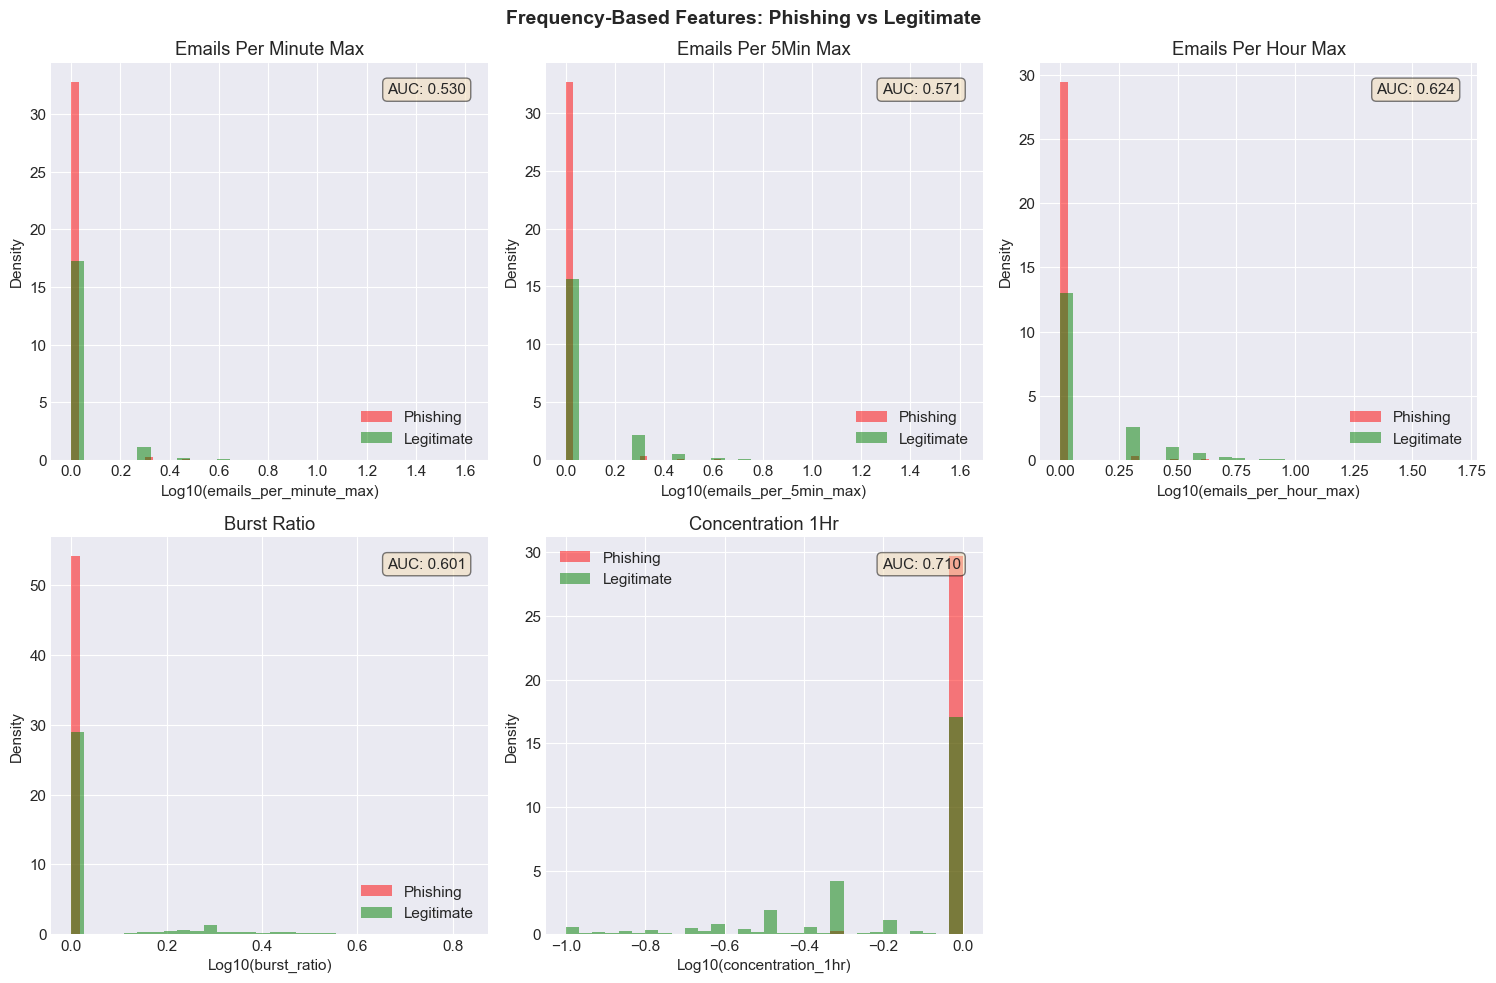

✅ Frequency pattern visualization complete


In [12]:
print("="*80)
print("FREQUENCY PATTERN VISUALIZATION")
print("="*80)

# Select top frequency features for visualization
freq_features = ['emails_per_minute_max', 'emails_per_5min_max', 'emails_per_hour_max', 
                 'burst_ratio', 'concentration_1hr']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Frequency-Based Features: Phishing vs Legitimate', fontsize=14, fontweight='bold')

for idx, feature in enumerate(freq_features):
    ax = axes[idx // 3, idx % 3]
    
    # Create log-scale for better visualization
    phish_data = phishing_senders[feature].clip(lower=0.1)
    legit_data = legitimate_senders[feature].clip(lower=0.1)
    
    # Plot distributions
    ax.hist(np.log10(phish_data), bins=30, alpha=0.5, label='Phishing', color='red', density=True)
    ax.hist(np.log10(legit_data), bins=30, alpha=0.5, label='Legitimate', color='green', density=True)
    
    ax.set_xlabel(f'Log10({feature})')
    ax.set_ylabel('Density')
    ax.set_title(feature.replace('_', ' ').title())
    ax.legend()
    
    # Add AUC score
    feature_auc = comparison_df[comparison_df['Feature'] == feature]['AUC'].values[0]
    ax.text(0.95, 0.95, f'AUC: {feature_auc:.3f}', transform=ax.transAxes, 
            ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

print("✅ Frequency pattern visualization complete")

## Part 7: Burst Pattern Analysis

BURST PATTERN ANALYSIS

📊 Burst Pattern Statistics:
  • Burst senders: 567 (1.8%)
    - Phishing: 394 (69.5%)
    - Legitimate: 173 (30.5%)

  • Campaign-like senders: 2 (0.0%)
    - Phishing: 0 (0.0%)
    - Legitimate: 2 (100.0%)

  • Hit-and-run senders: 0 (0.0%)
    - Phishing: 0 (nan%)
    - Legitimate: 0 (nan%)


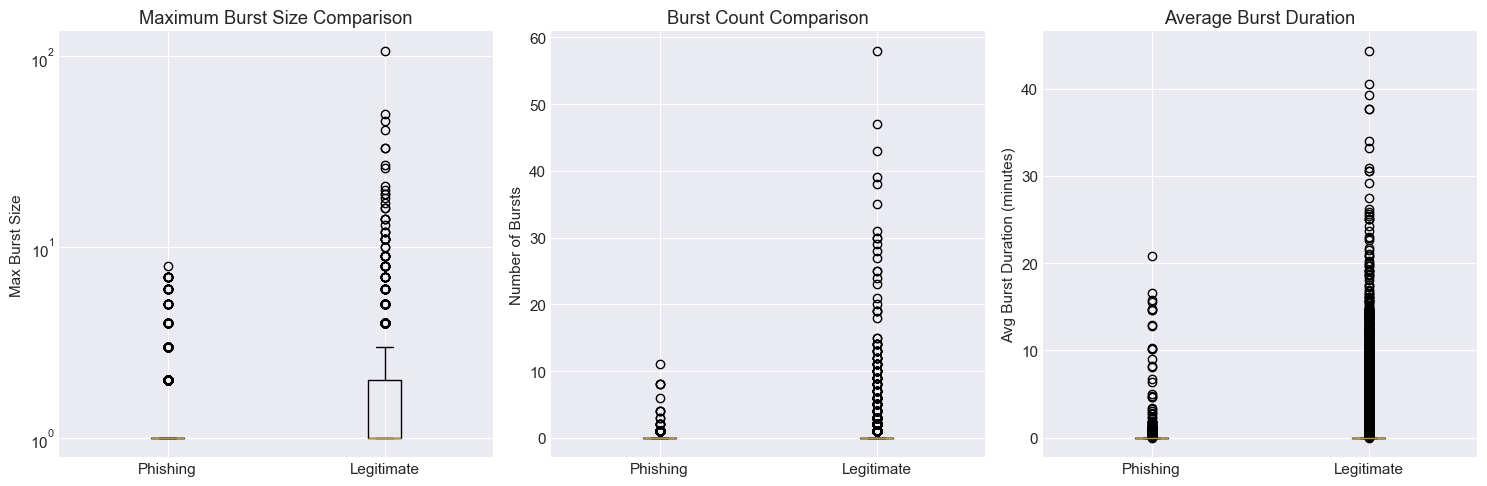


✅ Burst pattern analysis complete


In [13]:
print("="*80)
print("BURST PATTERN ANALYSIS")
print("="*80)

# Analyze burst patterns
burst_senders = sender_features[sender_features['is_burst_sender'] == 1]
campaign_senders = sender_features[sender_features['campaign_likelihood'] == 1]
hit_run_senders = sender_features[sender_features['hit_and_run'] == 1]

print("\n📊 Burst Pattern Statistics:")
print(f"  • Burst senders: {len(burst_senders):,} ({len(burst_senders)/len(sender_features)*100:.1f}%)")
print(f"    - Phishing: {(burst_senders['label']==1).sum():,} ({(burst_senders['label']==1).mean()*100:.1f}%)")
print(f"    - Legitimate: {(burst_senders['label']==0).sum():,} ({(burst_senders['label']==0).mean()*100:.1f}%)")

print(f"\n  • Campaign-like senders: {len(campaign_senders):,} ({len(campaign_senders)/len(sender_features)*100:.1f}%)")
print(f"    - Phishing: {(campaign_senders['label']==1).sum():,} ({(campaign_senders['label']==1).mean()*100:.1f}%)")
print(f"    - Legitimate: {(campaign_senders['label']==0).sum():,} ({(campaign_senders['label']==0).mean()*100:.1f}%)")

print(f"\n  • Hit-and-run senders: {len(hit_run_senders):,} ({len(hit_run_senders)/len(sender_features)*100:.1f}%)")
print(f"    - Phishing: {(hit_run_senders['label']==1).sum():,} ({(hit_run_senders['label']==1).mean()*100:.1f}%)")
print(f"    - Legitimate: {(hit_run_senders['label']==0).sum():,} ({(hit_run_senders['label']==0).mean()*100:.1f}%)")

# Visualize burst characteristics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Burst size distribution
axes[0].boxplot([
    phishing_senders['max_burst_size'].dropna(),
    legitimate_senders['max_burst_size'].dropna()
], labels=['Phishing', 'Legitimate'])
axes[0].set_ylabel('Max Burst Size')
axes[0].set_title('Maximum Burst Size Comparison')
axes[0].set_yscale('log')

# Number of bursts
axes[1].boxplot([
    phishing_senders['num_bursts'].dropna(),
    legitimate_senders['num_bursts'].dropna()
], labels=['Phishing', 'Legitimate'])
axes[1].set_ylabel('Number of Bursts')
axes[1].set_title('Burst Count Comparison')

# Burst duration
axes[2].boxplot([
    phishing_senders['avg_burst_duration'].dropna(),
    legitimate_senders['avg_burst_duration'].dropna()
], labels=['Phishing', 'Legitimate'])
axes[2].set_ylabel('Avg Burst Duration (minutes)')
axes[2].set_title('Average Burst Duration')

plt.tight_layout()
plt.show()

print("\n✅ Burst pattern analysis complete")

## Part 8: Temporal Entropy and Randomness Analysis

TEMPORAL ENTROPY AND RANDOMNESS ANALYSIS


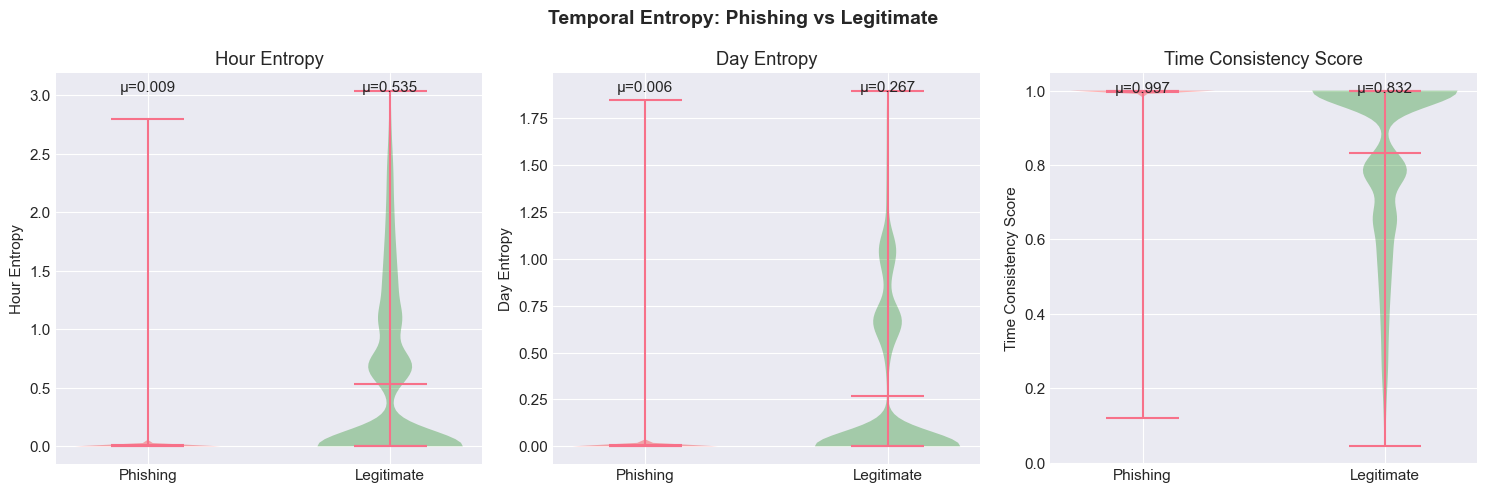


🤖 Bot-like Behavior Indicators:

Senders with >80% emails at :00 minute:
  Total: 11
  Phishing: 4 (36.4%)

Senders with very low hour entropy (<0.5):
  Total: 28,638
  Phishing: 25,984 (90.7%)

Senders with >90% emails at round minutes (:00, :05, :10, etc):
  Total: 124
  Phishing: 67 (54.0%)

✅ Entropy analysis complete


In [14]:
print("="*80)
print("TEMPORAL ENTROPY AND RANDOMNESS ANALYSIS")
print("="*80)

# Entropy comparison
entropy_features = ['hour_entropy', 'day_entropy', 'time_consistency_score']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Temporal Entropy: Phishing vs Legitimate', fontsize=14, fontweight='bold')

for idx, feature in enumerate(entropy_features):
    ax = axes[idx]
    
    # Violin plot for better distribution visualization
    data = [
        phishing_senders[feature].dropna(),
        legitimate_senders[feature].dropna()
    ]
    
    parts = ax.violinplot(data, positions=[1, 2], widths=0.6, showmeans=True, showmedians=True)
    
    # Color the violin plots
    colors = ['red', 'green']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.3)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Phishing', 'Legitimate'])
    ax.set_ylabel(feature.replace('_', ' ').title())
    ax.set_title(feature.replace('_', ' ').title())
    
    # Add mean values
    phish_mean = phishing_senders[feature].mean()
    legit_mean = legitimate_senders[feature].mean()
    ax.text(1, ax.get_ylim()[1] * 0.95, f'μ={phish_mean:.3f}', ha='center')
    ax.text(2, ax.get_ylim()[1] * 0.95, f'μ={legit_mean:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Bot-like behavior analysis
print("\n🤖 Bot-like Behavior Indicators:")
print("="*50)

# Senders with zero minute preference (likely automated)
zero_minute_senders = sender_features[sender_features['zero_minute_ratio'] > 0.8]
print(f"\nSenders with >80% emails at :00 minute:")
print(f"  Total: {len(zero_minute_senders):,}")
print(f"  Phishing: {(zero_minute_senders['label']==1).sum():,} ({(zero_minute_senders['label']==1).mean()*100:.1f}%)")

# Senders with perfect regularity (low entropy)
low_entropy = sender_features[sender_features['hour_entropy'] < 0.5]
print(f"\nSenders with very low hour entropy (<0.5):")
print(f"  Total: {len(low_entropy):,}")
print(f"  Phishing: {(low_entropy['label']==1).sum():,} ({(low_entropy['label']==1).mean()*100:.1f}%)")

# Round minute preference
round_minute = sender_features[sender_features['round_minute_ratio'] > 0.9]
print(f"\nSenders with >90% emails at round minutes (:00, :05, :10, etc):")
print(f"  Total: {len(round_minute):,}")
print(f"  Phishing: {(round_minute['label']==1).sum():,} ({(round_minute['label']==1).mean()*100:.1f}%)")

print("\n✅ Entropy analysis complete")

## Part 9: Finding Optimal Time Windows

FINDING OPTIMAL TIME WINDOWS FOR DISCRIMINATION


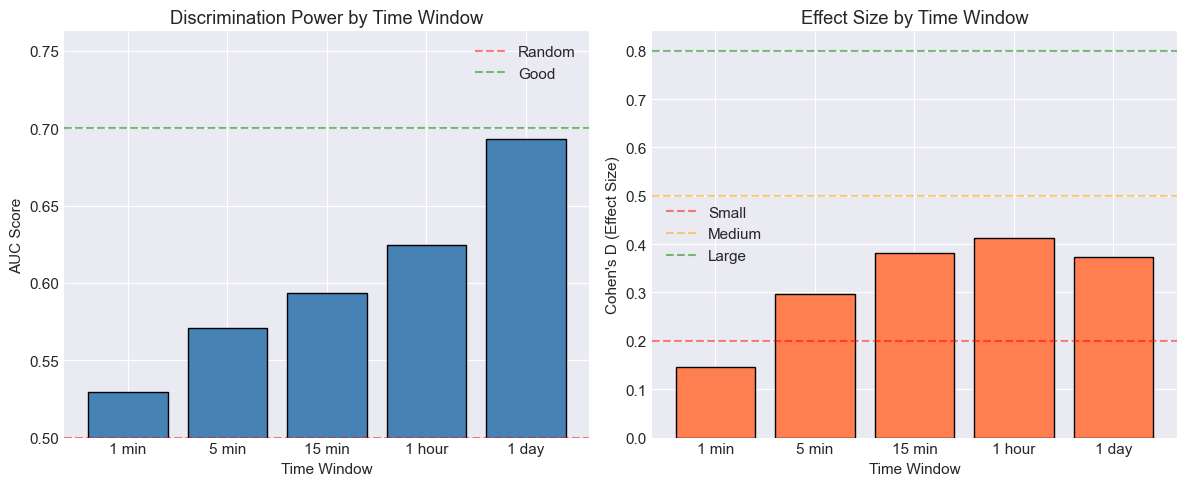


📊 Optimal Time Windows:
Window               Feature    AUC  Cohens_D
 1 day    emails_per_day_max 0.6933    0.3732
1 hour   emails_per_hour_max 0.6242    0.4121
15 min  emails_per_15min_max 0.5934    0.3809
 5 min   emails_per_5min_max 0.5708    0.2977
 1 min emails_per_minute_max 0.5298    0.1449

🎯 Best performing window: 1 day (AUC = 0.6933)


In [15]:
print("="*80)
print("FINDING OPTIMAL TIME WINDOWS FOR DISCRIMINATION")
print("="*80)

# Test different window sizes
window_features = [
    'emails_per_minute_max',
    'emails_per_5min_max', 
    'emails_per_15min_max',
    'emails_per_hour_max',
    'emails_per_day_max'
]

window_names = ['1 min', '5 min', '15 min', '1 hour', '1 day']

window_performance = []
for feature, name in zip(window_features, window_names):
    auc = comparison_df[comparison_df['Feature'] == feature]['AUC'].values[0]
    cohens_d = comparison_df[comparison_df['Feature'] == feature]['Cohens_D'].values[0]
    window_performance.append({
        'Window': name,
        'Feature': feature,
        'AUC': auc,
        'Cohens_D': cohens_d
    })

window_df = pd.DataFrame(window_performance)

# Visualize window performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# AUC by window size
ax1.bar(window_df['Window'], window_df['AUC'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Time Window')
ax1.set_ylabel('AUC Score')
ax1.set_title('Discrimination Power by Time Window')
ax1.set_ylim([0.5, max(window_df['AUC']) * 1.1])
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random')
ax1.axhline(y=0.7, color='g', linestyle='--', alpha=0.5, label='Good')
ax1.legend()

# Effect size by window
ax2.bar(window_df['Window'], window_df['Cohens_D'], color='coral', edgecolor='black')
ax2.set_xlabel('Time Window')
ax2.set_ylabel("Cohen's D (Effect Size)")
ax2.set_title('Effect Size by Time Window')
ax2.axhline(y=0.2, color='r', linestyle='--', alpha=0.5, label='Small')
ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Medium')
ax2.axhline(y=0.8, color='g', linestyle='--', alpha=0.5, label='Large')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Optimal Time Windows:")
print("="*50)
print(window_df.sort_values('AUC', ascending=False).to_string(index=False))

best_window = window_df.sort_values('AUC', ascending=False).iloc[0]
print(f"\n🎯 Best performing window: {best_window['Window']} (AUC = {best_window['AUC']:.4f})")

## Part 10: Feature Correlation and Selection

In [16]:
print("="*80)
print("FEATURE CORRELATION AND SELECTION")
print("="*80)

# Select numerical features only
numerical_features = sender_features[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
corr_matrix = sender_features[numerical_features].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature1': corr_matrix.columns[i],
                'Feature2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️ Highly Correlated Feature Pairs (|r| > 0.8):")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
    print("\n💡 Consider removing one feature from each highly correlated pair")
else:
    print("\n✅ No highly correlated feature pairs found (|r| > 0.8)")

# Feature importance based on multiple metrics
feature_importance = comparison_df[['Feature', 'AUC', 'Cohens_D']].copy()
feature_importance['Combined_Score'] = (feature_importance['AUC'] - 0.5) * 2 + feature_importance['Cohens_D']
feature_importance = feature_importance.sort_values('Combined_Score', ascending=False)

print("\n🏆 Top 20 Features by Combined Importance Score:")
print("="*70)
print(f"{'Rank':<6} {'Feature':<30} {'AUC':<10} {'Effect Size':<12} {'Score':<10}")
print("-"*70)

for idx, row in feature_importance.head(20).iterrows():
    rank = list(feature_importance.index).index(idx) + 1
    print(f"{rank:<6} {row['Feature']:<30} {row['AUC']:<10.4f} {row['Cohens_D']:<12.4f} {row['Combined_Score']:<10.4f}")

FEATURE CORRELATION AND SELECTION

⚠️ Highly Correlated Feature Pairs (|r| > 0.8):
                    Feature1                     Feature2  Correlation
                hour_entropy       time_consistency_score      -1.0000
             inter_email_max              max_session_gap       1.0000
            inter_email_mean              avg_session_gap       0.9999
             inter_email_min              min_session_gap       0.9998
                total_emails          pattern_break_count       0.9931
       active_duration_hours              max_session_gap       0.9912
       active_duration_hours              inter_email_max       0.9911
                acceleration               velocity_trend       0.9874
            inter_email_mean              inter_email_min       0.9873
            inter_email_mean              min_session_gap       0.9873
             avg_session_gap              min_session_gap       0.9872
             inter_email_min              avg_session_gap       0

## Part 11: Rule-Based Insights

In [17]:
print("="*80)
print("RULE-BASED INSIGHTS FOR QUICK FILTERING")
print("="*80)

# Find thresholds for high-confidence predictions
def find_optimal_threshold(feature_data, labels, target_precision=0.9):
    """
    Find threshold that gives target precision for phishing detection
    """
    from sklearn.metrics import precision_recall_curve
    
    # Remove NaN values
    valid_idx = ~feature_data.isna()
    feature_data = feature_data[valid_idx]
    labels = labels[valid_idx]
    
    if len(feature_data) == 0 or feature_data.nunique() <= 1:
        return None, None, None
    
    precision, recall, thresholds = precision_recall_curve(labels, feature_data)
    
    # Find threshold closest to target precision
    valid_idx = precision >= target_precision
    if valid_idx.any():
        idx = np.where(valid_idx)[0][0]
        return thresholds[idx] if idx < len(thresholds) else None, precision[idx], recall[idx]
    return None, None, None

print("\n🎯 High-Confidence Rules for Phishing Detection (≥90% Precision):")
print("="*80)

# Test key features for rules
rule_features = [
    ('emails_per_5min_max', 'greater'),
    ('burst_ratio', 'greater'),
    ('night_ratio', 'greater'),
    ('hour_entropy', 'less'),
    ('time_consistency_score', 'greater'),
    ('campaign_likelihood', 'equal'),
    ('hit_and_run', 'equal')
]

rules = []
for feature, direction in rule_features:
    if feature not in sender_features.columns:
        continue
        
    feature_data = sender_features[feature].copy()
    labels = sender_features['label'].copy()
    
    # Adjust for direction
    if direction == 'less':
        feature_data = -feature_data
    
    threshold, precision, recall = find_optimal_threshold(feature_data, labels, 0.9)
    
    if threshold is not None:
        if direction == 'less':
            threshold = -threshold
        
        # Calculate coverage
        if direction == 'greater':
            coverage = (sender_features[feature] > threshold).mean()
        elif direction == 'less':
            coverage = (sender_features[feature] < threshold).mean()
        else:  # equal
            coverage = (sender_features[feature] == 1).mean()
        
        rules.append({
            'Feature': feature,
            'Operator': direction,
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'Coverage': coverage
        })

if rules:
    rules_df = pd.DataFrame(rules).sort_values('Recall', ascending=False)
    
    for _, rule in rules_df.iterrows():
        op_symbol = '>' if rule['Operator'] == 'greater' else '<' if rule['Operator'] == 'less' else '=='
        print(f"\n📌 Rule: {rule['Feature']} {op_symbol} {rule['Threshold']:.3f}")
        print(f"   → Precision: {rule['Precision']*100:.1f}%")
        print(f"   → Recall: {rule['Recall']*100:.1f}%")
        print(f"   → Coverage: {rule['Coverage']*100:.1f}% of all senders")

print("\n💡 These rules can be used for immediate filtering or as features in your model")

RULE-BASED INSIGHTS FOR QUICK FILTERING

🎯 High-Confidence Rules for Phishing Detection (≥90% Precision):

📌 Rule: hour_entropy < 0.687
   → Precision: 90.1%
   → Recall: 99.0%
   → Coverage: 93.2% of all senders

📌 Rule: time_consistency_score > 0.784
   → Precision: 90.1%
   → Recall: 99.0%
   → Coverage: 93.2% of all senders

📌 Rule: night_ratio > 0.667
   → Precision: 90.0%
   → Recall: 32.3%
   → Coverage: 30.2% of all senders

💡 These rules can be used for immediate filtering or as features in your model


## Part 12: Export Final Feature Matrix

In [19]:
print("="*80)
print("EXPORTING FINAL FEATURE MATRIX")
print("="*80)

# ==================== EXPORT CONTROL ====================
# Set this to True to export files, False to skip export
EXPORT_ENABLED = True
# ========================================================

if not EXPORT_ENABLED:
    print("\n⚠️  EXPORT DISABLED - Set EXPORT_ENABLED = True to export files")
    print("="*80)
else:
    # Select top features based on importance
    top_features = feature_importance.head(25)['Feature'].tolist()

    # Ensure we have sender and label columns
    export_columns = ['sender'] + top_features + ['label']
    export_columns = [col for col in export_columns if col in sender_features.columns]

    # Create final feature matrix
    final_features = sender_features[export_columns].copy()

    # Save to CSV - notebook is already in notebooks/ directory, so just use filename
    output_filename = 'sender_temporal_features_final.csv'
    final_features.to_csv(output_filename, index=False)

    print(f"\n✅ Final feature matrix exported to '{output_filename}'")
    print(f"\n📊 Summary:")
    print(f"  • Total senders: {len(final_features):,}")
    print(f"  • Features selected: {len(top_features)}")
    print(f"  • Phishing senders: {(final_features['label']==1).sum():,} ({(final_features['label']==1).mean()*100:.1f}%)")
    print(f"  • Legitimate senders: {(final_features['label']==0).sum():,} ({(final_features['label']==0).mean()*100:.1f}%)")

    print(f"\n📋 Top features included:")
    for i in range(0, len(top_features), 3):
        print("  ", ", ".join(top_features[i:i+3]))

    print("\n" + "="*80)
    print("✅ ANALYSIS COMPLETE!")
    print("="*80)
    print(f"\n🎯 Ready for model training with temporal features!")
    print(f"   Output: {output_filename}")

EXPORTING FINAL FEATURE MATRIX

✅ Final feature matrix exported to 'sender_temporal_features_final.csv'

📊 Summary:
  • Total senders: 31,001
  • Features selected: 25
  • Phishing senders: 26,275 (84.8%)
  • Legitimate senders: 4,726 (15.2%)

📋 Top features included:
   campaign_intensity, emails_per_minute_p90, emails_per_minute_p95
   emails_per_5min_median, emails_per_5min_p90, emails_per_5min_p95
   percent_emails_in_first_hour, concentration_1hr, activity_concentration
   rapid_succession_ratio, unique_hours, emails_per_minute_p99
   time_consistency_score, hour_entropy, emails_per_15min_p90
   avg_burst_size, session_length_cv, mean_velocity
   inter_email_cv, single_session, front_loading_score
   emails_per_15min_p95, unique_days, emails_per_5min_p99
   day_entropy

✅ ANALYSIS COMPLETE!

🎯 Ready for model training with temporal features!
   Output: sender_temporal_features_final.csv
